# Gradio app

In [38]:
# Install fast ai and duckduckgo

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search fastbook

In [39]:
import fastbook
fastbook.setup_book()
from fastai.vision.widgets import *
from fastbook import *

## Steps
We'll build a food vs no food classifier app and deploy it HuggingFace spaces. For that
- Use duckduckgo api to find images of food.
- Use duckduckgo api to find images of not food.
- Create a dataloader
- Use the dataloader to finetune resnet18
- Once finetuned, export the model
- Create a huggingface space.
- Load the model to the space
- Write the app to upload a image
- Show prediction whether uploaded image is food or not.

In [40]:
?search_images_ddg

Signature: search_images_ddg(term, max_images=200)
Docstring: Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images
File:      /opt/conda/lib/python3.10/site-packages/fastbook/__init__.py
Type:      function

### Download Food Images

In [41]:
keywords_image_counts = {
    'food' : 100,
    'burger': 20,
    'pasta':  20,
    'pizza': 20,
    'chiken tikka': 20,
    'noodles': 20
}

path = Path('images/')

if not path.exists():
    path.mkdir()
    for ft, count in keywords_image_counts.items():
        dest = (path/f'food')
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(ft, max_images=count)
        download_images(dest, urls=results)

In [42]:
fns = get_image_files(path)
failed = verify_images(fns)
len(failed)

0

In [43]:
failed.map(Path.unlink)

(#0) []

In [44]:
len(list(Path('images/food').glob('*')))

185

## Download "no" food images

In [54]:
keywords_image_counts = {
    'mountains' : 20,
    'animals': 20,
    'plants':  20,
    'city': 20,
    'people': 20,
    'vehicles': 10,
    'books': 10,
    'computer': 10,
    'furniture': 10,
    'fashion clothing': 10,
    'art': 10,
    'stars and planets': 10,
    'birds': 10,
    'houses': 10,
    'electronics': 10
}

path = Path('images/')


for ft, count in keywords_image_counts.items():
    dest = (path/f'not_food')
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(ft, max_images=count)
    download_images(dest, urls=results)

In [55]:
fns = get_image_files(path)
failed = verify_images(fns)
len(failed)

5

In [56]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [57]:
len(list(Path('images/not_food').glob('*')))

188

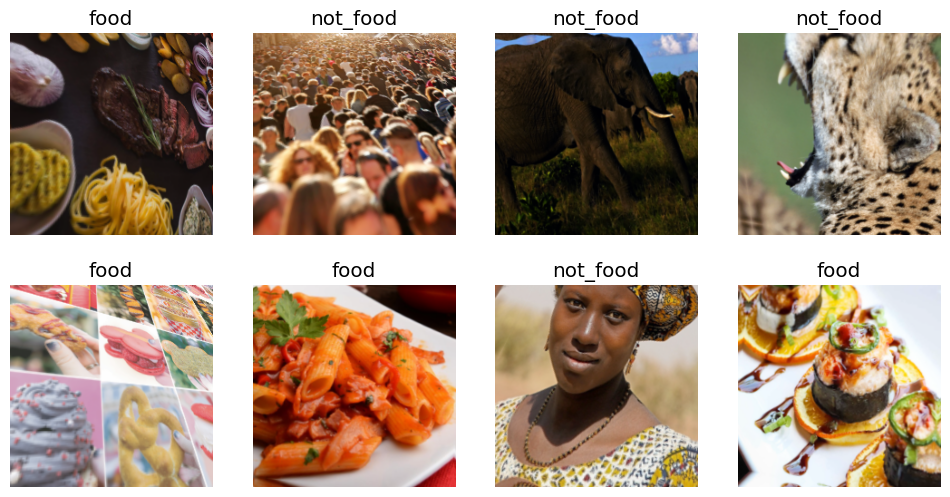

In [58]:
path = Path('images/')
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label
)

db = db.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=2))

dls = db.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2)

In [59]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.886293,2.093464,0.506849,00:35


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.292401,0.827107,0.273973,00:35
1,0.217442,0.300042,0.109589,00:35
2,0.172283,0.066884,0.041096,00:34
3,0.143413,0.020610,0.000000,00:34
4,0.122913,0.008516,0.000000,00:36


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


May be slighly overfit, but looks good.

In [60]:
learn.export('model.pkl')

Upload the model to HF (There is an sdk for that)

In [61]:
%pip install -Uqq huggingface-hub

In [62]:
from huggingface_hub import notebook_login
notebook_login()

In [64]:
# upload model

from huggingface_hub import upload_file

upload_file(
    path_or_fileobj="/kaggle/working/model.pkl",
    path_in_repo="model2.pkl",
    repo_id="mandliya/food_or_no_food"
)

model.pkl:   0%|          | 0.00/47.0M [00:00<?, ?B/s]

'https://huggingface.co/mandliya/food_or_no_food/blob/main/model2.pkl'

In [65]:
%pip install -Uqq gradio

In [71]:
from fastai.vision.all import *
import gradio as gr
from huggingface_hub import hf_hub_download
from gradio.components import Image, Label


class FoodOrNoFood:
    def __init__(self) -> None:
        self.repo_id = 'mandliya/food_or_no_food'
        self.model_path = 'model/model.pkl'
        self.download_model()
        self.learn = load_learner(self.model_path)
        self.classes = self.learn.dls.vocab
    
    def download_model(self):
        hf_hub_download(self.repo_id, filename='model2.pkl', local_dir='model')

    def predict(self, img):
        _, _ , probs = self.learn.predict(img)
        return dict(zip(self.classes, map(float, probs)))


def main():
    try:
        food_or_no_food = FoodOrNoFood()
        title = "Food or No Food"
        description = "A web app that classifies images as food or not food."
        examples = ['examples/indian_food.jpg', 'examples/pizza.jpg', 'examples/cat.jpg', 'examples/dog.jpg']

        gr.Interface(fn=food_or_no_food.predict, 
                    inputs=Image(shape=(224, 224)), 
                    outputs=Label(),
                    examples=examples,
                    title=title,
                    description=description).launch(inline=True, share=True)
    except Exception as e:
        print(e)

In [72]:
# create a HF space and run this code there in a gradio space
main()